## Denoising Diffusion Probabilistic Models with miniai

Note, this notebook is explained in Lesson 

### Imports

In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [3]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

Pad the mnist image up to 32x32 with zeros around the edge. Subtract 0.5 which should make the  mean equal to zero

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

bs = 512
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=7)

  0%|          | 0/2 [00:00<?, ?it/s]

### Explore the effect of different scheduling types 

In [5]:
from types import SimpleNamespace

In [6]:
def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [7]:
def abar(t, T): return (t/T*math.pi/2).cos()**2

In [8]:
def cos_sched(n_steps=1000):
    ts = torch.linspace(0, n_steps-1, n_steps)
    ab = abar(ts,n_steps)
    alp = ab/abar(ts-1,n_steps)
    return SimpleNamespace(a=alp, abar=ab, sig=(1-alp).sqrt())

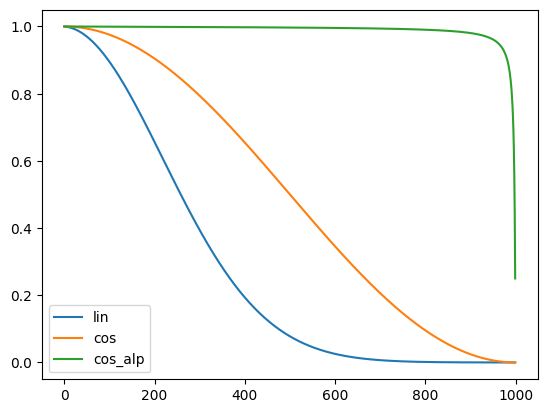

In [9]:
lin_abar = linear_sched().abar
cos_abar = cos_sched().abar
plt.plot(lin_abar, label='lin')
plt.plot(cos_abar, label='cos')
plt.plot(cos_sched().a, label='cos_alp')
plt.legend();

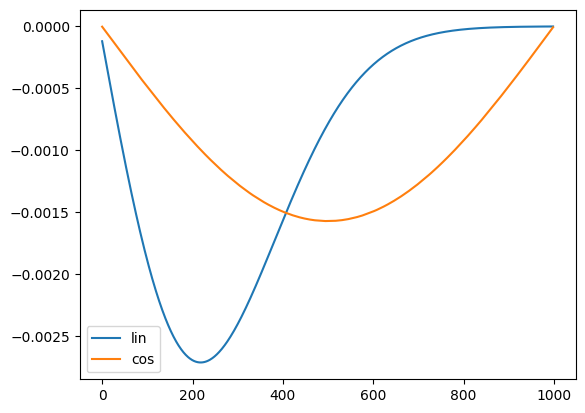

In [10]:
# Plot the effective derivative of the curves
plt.plot(lin_abar[1:]-lin_abar[:-1], label='lin')
plt.plot(cos_abar[1:]-cos_abar[:-1], label='cos')
plt.legend();

It can be seen that the gradient of the linear changes are higher and that nothing much happens at high values of T.  To make the changes more uniform 

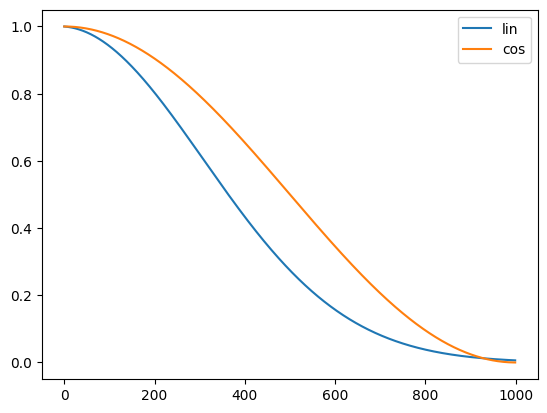

In [11]:
lin_abar = linear_sched(betamax=0.01).abar
plt.plot(lin_abar, label='lin')
plt.plot(cos_abar, label='cos')
plt.legend();

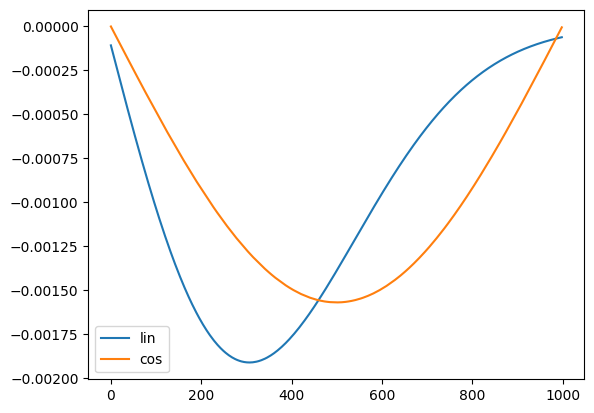

In [12]:
plt.plot(lin_abar[1:]-lin_abar[:-1], label='lin')
plt.plot(cos_abar[1:]-cos_abar[:-1], label='cos')
plt.legend();

Using the modified linear scheduler, we can create 

In [10]:
n_steps = 1000
lin_abar = linear_sched(betamax=0.01)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig

In [11]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [12]:
dt = dls.train
xb,yb = next(iter(dt))

In [13]:
(xt,t),ε = noisify(xb[:25],alphabar)
t

tensor([876, 414,  26, 335, 620, 924, 950, 113, 378,  14, 210, 954, 231, 572,
        315, 295, 567, 706, 749, 876,  73, 111, 899, 213, 541])

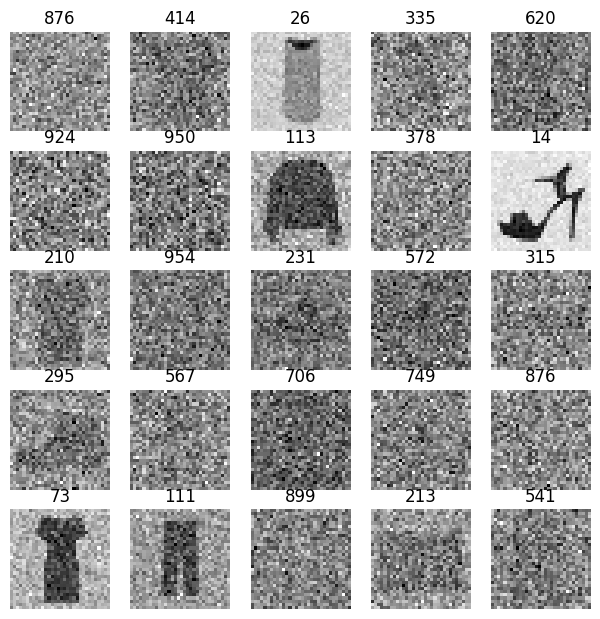

In [17]:

titles = fc.map_ex(t[:25], '{}')
show_images(xt[:25], imsize=1.5, titles=titles)

There is a more even spread of noise and the noisification is not so extreme as in the earlier images

### Training 

In [14]:
from diffusers import UNet2DModel

In [15]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [16]:
def init_ddpm(model):
    """ Initialise ddmp model with orthogonal weights for the down blocks and zeros for the
    up blocks
    """
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [17]:
def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds, nw=4): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, 
                                         num_workers=nw)

In [18]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

#### Train the diffusion model with the lin_abar scheduler defined above

Note that the number of conv channels has been doubled to see how much that increase accuracy

In [23]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), 
             norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.201,0,train
0.043,0,eval
0.036,1,train
0.035,1,eval
0.031,2,train
0.031,2,eval
0.029,3,train
0.029,3,eval
0.028,4,train
0.029,4,eval


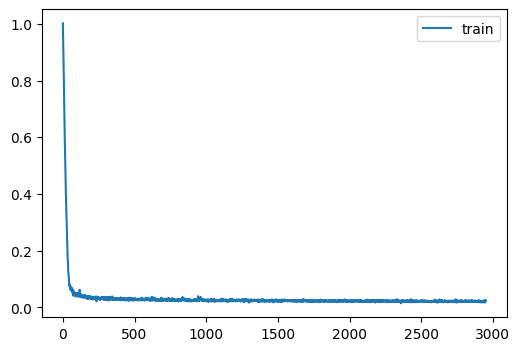

In [24]:
learn.fit(epochs)

In [19]:
mdl_path = Path('/home/models')

In [29]:
# torch.save(learn.model, mdl_path/'fashion_ddpm3_25.pkl')

In [20]:
model = torch.load(mdl_path/'fashion_ddpm3_25.pkl').cuda()

Generate a sampler method for the model using the same scheduler

In [21]:
@torch.no_grad()
def sample(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds

In [22]:
n_samples = 512

In [23]:
%%time
samples = sample(model, (n_samples, 1, 32, 32))

CPU times: user 4min 7s, sys: 1.41 s, total: 4min 9s
Wall time: 4min 9s


In [24]:
s = (samples[-1]*2)#.clamp(-1,1)
s.min(),s.max()

(tensor(-1.0782), tensor(1.3900))

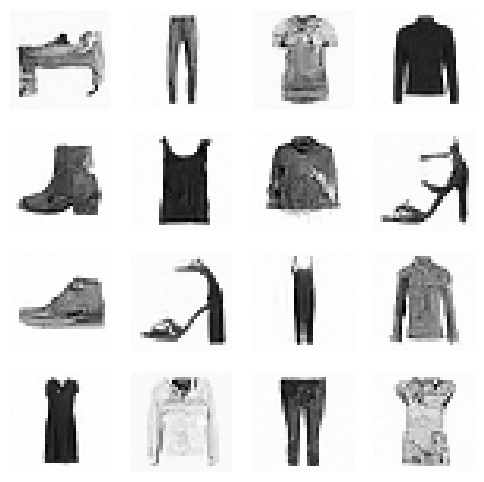

In [25]:
show_images(s[:16], imsize=1.5)

It is important to test the validity of the images generated using FID.  To do so we need to generate features for actual images and from the above samples using the classifier developed earlier.  As covered in previous notebooks we are taking features from the 6th block

In [26]:
@inplace
def transformi2(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

tds2 = dsd.with_transform(transformi2)
dls2 = DataLoaders.from_dd(tds2, bs, num_workers=fc.defaults.cpus)

cmodel = torch.load('/home/models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

In [27]:
from miniai.fid import ImageEval

In [28]:
# Create the evaluation instance using mnist samples (padded to 32x32)
ie = ImageEval(cmodel, dls2, cbs=[DeviceCB()])

In [29]:
# Feed the samples generate above into ie for evaluation
ie.fid(s)

11.212158203125

In [30]:
s.min(),s.max()

(tensor(-1.0782), tensor(1.3900))

In [31]:
ie.fid(xb)

645.66748046875

In [32]:
ie.fid(xb*2)

5.91094970703125

## Making the process more efficient - skip sampling 

In [33]:
@torch.no_grad()
def sample_skip(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        if t%3==0 or t<50: noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu().float())
    return preds

In [43]:
%%time
samples = sample_skip(model, (n_samples, 1, 32, 32))

CPU times: user 1min 33s, sys: 655 ms, total: 1min 34s
Wall time: 1min 34s


In [44]:
s = (samples[-1]*2)

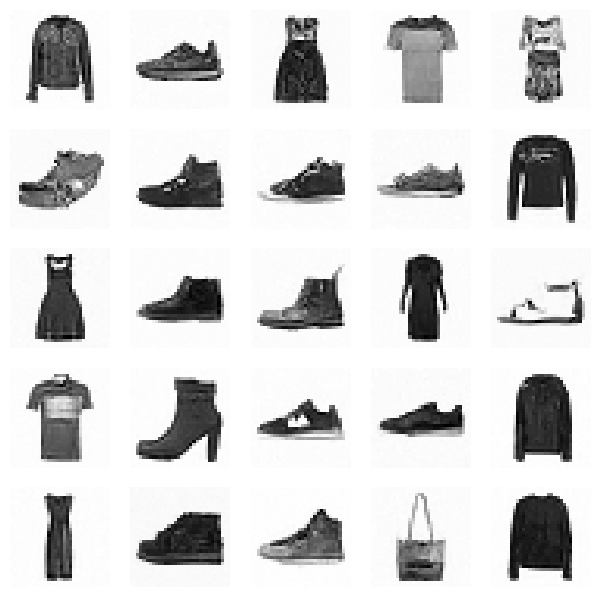

In [45]:
show_images(s[:25], imsize=1.5)

In [46]:
ie.fid(s)

14.21246337890625

Add additional skip steps

In [47]:
[t for t in range(n_steps) if (t+101)%((t+101)//100)==0]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 101,
 103,
 105,
 107,
 109,
 111,
 113,
 115,
 117,
 119,
 121,
 123,
 125,
 127,
 129,
 131,
 133,
 135,
 137,
 139,
 141,
 143,
 145,
 147,
 149,
 151,
 153,
 155,
 157,
 159,
 161,
 163,
 165,
 167,
 169,
 171,
 173,
 175,
 177,
 179,
 181,
 183,
 185,
 187,
 189,
 191,
 193,
 195,
 197,
 199,
 202,
 205,
 208,
 211,
 214,
 217,
 220,
 223,
 226,
 229,
 232,
 235,
 238,
 241,
 244,
 247,
 250,
 253,
 256,
 259,
 262,
 265,
 268,
 271,
 274,
 277,
 280,
 283,
 286,
 289,
 292,
 295,
 298,
 299,
 303,


In [48]:
@torch.no_grad()
def sample2(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    sample_at = {t for t in range(n_steps) if (t+101)%((t+101)//100)==0}
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        if t in sample_at: noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        if t in sample_at: preds.append(x_t.float().cpu())
    return preds

In [49]:
%%time
samples = sample2(model, (n_samples, 1, 32, 32))

CPU times: user 1min 16s, sys: 448 ms, total: 1min 16s
Wall time: 1min 16s


In [50]:
s = (samples[-1]*2)

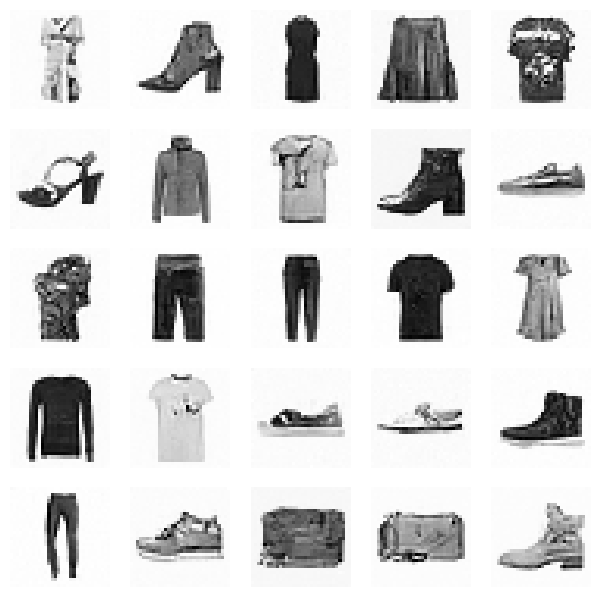

In [51]:
show_images(s[:25], imsize=1.5)

In [52]:
ie.fid(s)

9.57061767578125